<a href="https://colab.research.google.com/github/eaNODE/waibo/blob/master/text_classification_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TEXT CLASSIFICATION - EMOTION DETECTION KERAS CODE**
*`getting our hands on`*

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[+] data size from csv >>>  (40000,)
[+] label size from csv >>>  (40000,)

[+] Loading Glove Vectors ...

[+] Loaded GloVe Vectors Successfully!

[+] Embedding Matrix Generated with size >>>>  (32855, 50)

[+] embedding matrix is 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.067678    0.51832002  1.32599998 ... -0.65103     0.12924001
   0.48723999]
 [ 0.11626     0.53896999 -0.39513999 ... -0.39061999 -0.10885
   0.084513  ]
 ...
 [ 1.18879998  1.46720004 -0.99624002 ...  0.48704001  0.77978998
   0.38242999]
 [ 0.013849   -0.54549998 -0.077683   ...  0.67878002  0.46202999
   0.72376001]
 [ 0.023778   -0.80124003  0.1193     ... -1.06830001 -0.35703
   0.21013001]]

[+] Label Encoding Classes as 
{0: 'anger', 1: 'boredom

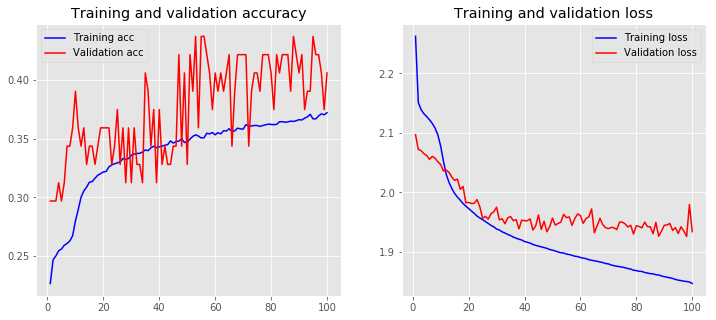

In [0]:
# -*- encoding: utf-8 -*-


import numpy as np, pandas as pd, os, sys, time, datetime, nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, save_model, Model
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, LSTM, Bidirectional, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
nltk.download('stopwords')
plt.style.use('ggplot')



# ===================================
# Preprocessing and formating
# ===================================

MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 50
dataFrame = pd.read_csv('/gdrive/My Drive/text_emotion_twitter.csv', encoding='utf-8')
# dataFrame is a matrix of 40000 rows X 4 cols
# dataFrame.values[[rows], [cols]]
x = dataFrame.values[:,3] # accessing third elements of all rows which is content/text => 40000 texts/contents
y = dataFrame.values[:,1] # accessing first elements of all rows which is label/emotions => 40000 labels/emotions
print("[+] data size from csv >>> ", x.shape)
print("[+] label size from csv >>> ", y.shape)


def uprint(*objects, sep=' ', end='\n', file=sys.stdout):
    enc = file.encoding
    if enc == 'UTF-8':
        print(*objects, sep=sep, end=end, file=file)
    else:
        f = lambda obj: str(obj).encode(enc, errors='backslashreplace').decode(enc)
        print(*map(f, objects), sep=sep, end=end, file=file)


def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label = 'Training acc')
    plt.plot(x, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    
def textToInput(x):
    stop_words = set(stopwords.words('english'))
    new_stop_words = set(stop_words)
    # adding woudlnt type of words into stopwords list
    for s in stop_words:
        new_stop_words.add(s.replace('\'',''))
        pass
    stop_words = new_stop_words
    print("\n[+] Excluding stopwords ...")


    # removing @ from default base filter, to remove that whole word, which might be considered as user or page name
    base_filters = '\n\t!"#$%&()*+,-./:;<=>?[\]^_`{|}~ '
    word_sequences = []
    for i in x:
        i = str(i)
    #     uprint(i)
        i = i.replace('\'', '')
        newlist = [x for x in text_to_word_sequence(i,filters = base_filters, lower = True) if not x.startswith("@")]
        filtered_sentence = [w for w in newlist if not w in stop_words] 
        word_sequences.append(filtered_sentence)
        pass
    # print("\n[+] word sequences >>> ", word_sequences) # len is : 40000
    # [ ['know', 'listenin', 'bad', 'habit', 'earlier', 'started', 'freakin', 'part'], ....... , ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'] ]

    

    # Tokenizing words to word indices
    tokenizer = Tokenizer()
    # fitting texts to tokenizer object
    tokenizer.fit_on_texts(word_sequences)
    word_indices = tokenizer.texts_to_sequences(word_sequences)
    word_index = tokenizer.word_index # size is 32855 cause its a dict with key as word and index as value
    # print("\n[+] word index >>> ", word_index) 
    # word_index : { 'im': 1, 'day': 2, 'good': 3, 'get': 4, 'like': 5, ......  , 'quot': 6, 'http': 7, 'go': 8, 'today': 9 }
    print("\n[+] Tokenized to Word indices as ")
    print(np.array(word_indices).shape) # size is 40000
    # print("\n[+] word indices >>> ", word_indices)
    # word_indices : [ [20, 3077, 57, 4396, 714, 489, 1014, 433], ...... , [8964, 177, 74, 319, 3327, 2077, 192], [2555, 3963, 1598, 143] ]



    # padding word_indices
    # >>> pad_sequences([[1, 2, 3], [3, 4, 5, 6], [7, 8]])
    # array([[0, 1, 2, 3],
    #        [3, 4, 5, 6],
    #        [0, 0, 7, 8]], dtype=int32)

    x_data = pad_sequences(word_indices, maxlen=MAX_SEQUENCE_LENGTH)
    print("\n[+] After padding data size is")
    print(x_data.shape) # (40000, 20)
    print("\n[+] padded x_data >>> ")
    print(x_data)
    # [[    0     0     0 ...   489  1014   433]
    #  [    0     0     0 ...  3327  2077   192]
    #  [    0     0     0 ...  3963  1598   143]
    #  ...
    #  [    0     0     0 ...  1390   165     2]
    #  [    0     0     0 ...  1135    19   336]
    #  [    0     0     0 ... 32852 32853 32854]]
    return x_data




# ===================================
# Building Embedding Layer
# ===================================


# using pretrained glove vector
print("\n[+] Loading Glove Vectors ...")
embeddings_index = {}
f = open(os.path.join('', '/gdrive/My Drive/glove.6B.50d.txt'),'r',encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     print("[+] coefs >>> ", coefs)
    embeddings_index[word] = coefs
f.close()

print('\n[+] Loaded GloVe Vectors Successfully!')


# embedding_matrix size is : vocab + 1 X 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print("\n[+] Embedding Matrix Generated with size >>>> ", embedding_matrix.shape)
print("\n[+] embedding matrix is ")
print(embedding_matrix)
# it has len(word_index) + 1 rows and 50 cols which is (32855, 50)
# [[ 0.          0.          0.         ...  0.          0.
#    0.        ]
#  [-0.067678    0.51832002  1.32599998 ... -0.65103     0.12924001
#    0.48723999]
#  [ 0.11626     0.53896999 -0.39513999 ... -0.39061999 -0.10885
#    0.084513  ]
#  ...
#  [ 1.18879998  1.46720004 -0.99624002 ...  0.48704001  0.77978998
#    0.38242999]
#  [ 0.013849   -0.54549998 -0.077683   ...  0.67878002  0.46202999
#    0.72376001]
#  [ 0.023778   -0.80124003  0.1193     ... -1.06830001 -0.35703
#    0.21013001]]




"""
This layer acts as lookup table for vectors, given word index. 
It will return embedded word vector.
Embedding layer can only be used as first layer in Keras.
Our input layer will of be size : (None,20) ; None means variable number.
As we have padded 20 words for each input, in data preparation stage. 
we have 20 word indices in each row.
Output of Embedding layer will be fed to this LSTM layer.
"""
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)


# ===================================
# One Hot encoding Labels
# ===================================


# Example from sklearn API :

# >>> le = preprocessing.LabelEncoder()
# >>> le.fit(["paris", "paris", "tokyo", "amsterdam"])
# LabelEncoder()
# >>> list(le.classes_)
# ['amsterdam', 'paris', 'tokyo']
# >>> le.transform(["tokyo", "tokyo", "paris"]) 
# array([2, 2, 1]...)
# >>> list(le.inverse_transform([2, 2, 1]))
# ['tokyo', 'tokyo', 'paris']


label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y) # Fit label encoder and return encoded labels
# print(label_encoder.classes_)
# print(label_encoder.transform(label_encoder.classes_)) 

le_name_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
print("\n[+] Label Encoding Classes as ")
print(le_name_mapping)
# {0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fun', 5: 'happiness', 6: 'hate', 7: 'love', 8: 'neutral', 9: 'relief', 10: 'sadness', 11: 'surprise', 12: 'worry'}



"""
to_categorical

Converts a class vector (integers) to binary class matrix.

Arguments

y: class vector to be converted into a matrix (integers from 0 to num_classes).
num_classes: total number of classes.
dtype: The data type expected by the input, as a string (float32, float64, int32...)

Return

A binary matrix representation of the input. The classes axis is placed last.

Example

# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
> labels
array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many
# columns as there are classes. The number of rows
# stays the same.
> to_categorical(labels)
array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]], dtype=float32)
       
"""

y_data = np_utils.to_categorical(integer_encoded)
print("\n[+] One Hot Encoded class shape with size ")
print(y_data.shape) # (40000 , 13)
print("\n[+] One hot encoded labels matrix")
print(y_data)
# [[0. 0. 1. ... 0. 0. 0.]
#  [0. 0. 0. ... 1. 0. 0.]
#  [0. 0. 0. ... 1. 0. 0.]
#  ...
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]]




# ===================================
# Building Model
# ===================================


"""
We’ll use LSTM layer with 100 units. This layer has 100 RNN Cells, 
this number is variable and can be adjusted according to our need and complexity of our data.
Input given to LSTM will be considered as (batch_size, timesteps, features).

-----------------------
return_sequences=True :
-----------------------
Output of RNN layer will include all the outputs from all the units/cells in that layer.
(None, 20,50) => LSTM(100, return_sequences=True) => (None, 20, 100)
In the next step, we’ll flatten.
(None, 20,100) => Flatten => (None,2000)
If you wish to connect a Dense layer directly to an Embedding layer, 
you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.

-----------------------------------------
Understanding Dense Layer (Last Layers) :
-----------------------------------------
We connect all the data that we get from previous levels using Dense Layers.. 
We keep reducing output units to (None, labels_count) by adding multiple Dense Layers.
(None, 2000) => Dense(300) => (None,300)
Adding another dense layer
(None,300) => Dense(labels_count) => (None,13)
13 is labels’ count in our problem. i.e Total number of emotions count.
Softmax is probability distribution activation function and helps 
in achieving better results by distributing probability among labels for a given input.
After adding this, we get 13 Outputs each lying between 0 and 1 for each input. 
Each output represents probability of that emotion for given input. One with highest value can be considered as our prediction.

--------
Conv1D :
--------
CNNs work the same way whether they have 1, 2, or 3 dimensions. 
The difference is the structure of the input data and how the filter, 
also known as a convolution kernel or feature detector, moves across the data.
A 1D CNN is very effective for deriving features from a fixed-length segment 
of the overall dataset, where it is not so important where the feature is located in the segment.
"""

x_data = textToInput(x)

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(30, 1, activation="relu"))
model.add(MaxPooling1D(4))
model.add(LSTM(100, return_sequences=True))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(y_data.shape[1], activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
print(model.summary())


print("Finished Preprocessing data ...")
print("[+] x_data shape >>> ", x_data.shape)
print("[+] y_data shape >>> ", y_data.shape)



# We gotta split our data into two parts, Training Data, Testing Data
# We use Training dataset to train our neural network. 
# Test dataset to provide an unbiased evaluation of a final model fit on the training dataset.
# Split arrays or matrices into random train and test subsets
print("[+] spliting data into training, testing set :")
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)


# # x_train
# [[    0     0     0 ...     0    93   866]
#  [    0     0     0 ...  1498  5908  7727]
#  [    0     0     0 ...   565  2943   162]
#  ...
#  [    0     0     0 ...  1056 10331 24539]
#  [    0     0     0 ...   520   995    71]
#  [    0     0     0 ...   565   789   129]] 
# # x_test
# [[    0     0     0 ...    49   595  2060]
#  [    0     0     0 ...  2583  3626  2401]
#  [    0     0     0 ...  3423  2463   398]
#  ...
#  [    0     0     0 ...   124    11 18737]
#  [    0     0     0 ...    69  8389  8389]
#  [    0     0     0 ...    15    27  5723]] 
# # y_train
# [[0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]
#  ...
#  [0. 0. 0. ... 0. 0. 1.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]] 
# # y_test
# [[0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 1. 0. 0.]
#  ...
#  [0. 0. 0. ... 0. 0. 1.]
#  [0. 0. 0. ... 0. 0. 0.]
#  [0. 0. 0. ... 0. 0. 0.]]




batch_size = 64
num_epochs = 100

"""
If you want to build a solid model you have to follow that specific protocol of 
splitting your data into three sets: One for training, 
one for validation and one for final evalution, which is the test set.
The idea is that you train on your training data and tune your 
model with the results of metrics (accuracy, loss etc) that you get from your validation set.
Your model doesn't "see" your validation set and isn´t in any way trained on it, 
but you as the architect and master of the hyperparameters tune the model according to this data. 
Therefore it indirectly influences your model because it directly influences 
your design decisions. You nudge your model to work well with the validation 
data and that can possibly bring in a tilt.
Exactly that is the reason you only evaluate your models final score on data 
that neither your model nor you yourself has used – and that is the third chunk of data, your test set.
Only this procedure makes sure you get an unaffected view of your models quality
and ability to generalize what is has learned on totally unseen data.

===========
Overfitting
===========
Overfitting occurs when a statistical model or machine learning algorithm captures the noise of the data.  
Intuitively, overfitting occurs when the model or the algorithm fits the data too well.  
Specifically, overfitting occurs if the model or algorithm shows low bias but high variance.  
Overfitting is often a result of an excessively complicated model, and it can be prevented by 
fitting multiple models and using validation or cross-validation to compare their predictive accuracies on test data.

============
Underfitting
============
Underfitting occurs when a statistical model or machine learning algorithm cannot 
capture the underlying trend of the data.  Intuitively, underfitting occurs when 
the model or the algorithm does not fit the data well enough.  Specifically, 
underfitting occurs if the model or algorithm shows low variance but high bias.  
Underfitting is often a result of an excessively simple model.
"""
x_valid, y_valid = x_train[:batch_size], y_train[:batch_size]
x_train2, y_train2 = x_train[batch_size:], y_train[batch_size:]




"""
Save the model after every epoch.
filepath can contain named formatting options, which will be filled 
with the values of epoch and keys in logs (passed in on_epoch_end).
For example: if filepath is weights.{epoch:02d}-{val_loss:.2f}.hdf5, 
then the model checkpoints will be saved with the epoch number and the validation loss in the filename.

Arguments

filepath: string, path to save the model file.
monitor: quantity to monitor.
verbose: verbosity mode, 0 or 1.
save_best_only: if save_best_only=True, the latest best model according 
    to the quantity monitored will not be overwritten.
    save_weights_only: if True, then only the model's weights will be saved 
    (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
mode: one of {auto, min, max}. If save_best_only=True, the decision to overwrite 
    the current save file is made based on either the maximization or the minimization 
    of the monitored quantity. For val_acc, this should be max, for val_loss this 
    should be min, etc. In auto mode, the direction is automatically inferred 
    from the name of the monitored quantity.
period: Interval (number of epochs) between checkpoints.
"""
# Now, we define check point conditions, 
# these checkpoints will save our model locally if there’s an improvement.
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
filepath = "/gdrive/My Drive/ted/ed-{epoch:02d}-{val_acc:.6f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'auto', save_weights_only = False)
callbacks_list = [checkpoint]


history = model.fit(x_train2, y_train2, validation_data = (x_valid, y_valid), batch_size = batch_size, epochs = num_epochs, callbacks = callbacks_list)
plot_history(history)

scores = model.evaluate(x_test, y_test, verbose = 0)
tr_scores = model.evaluate(x_train, y_train, verbose = False)
print("[+] Training Accuracy : {:.6f}".format(tr_scores[1]))
print("[+] Training Loss     : {:.6f}".format(tr_scores[0]))
te_scores = model.evaluate(x_test, y_test, verbose = False)
print("[+] Testing Accuracy  :  {:.6f}".format(te_scores[1]))
print("[+] Testing Loss      : {:.6f}".format(tr_scores[0]))






# **GETTING EMOTIONS OF OUR TEXT**
*`predicting using our model`*

In [116]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from nltk.corpus import stopwords
import numpy as np
import emojis
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from google.colab import drive
drive.mount('/gdrive')
nltk.download('stopwords')

def textToInput(x):
    stop_words = set(stopwords.words('english'))
    new_stop_words = set(stop_words)
    for s in stop_words:
        new_stop_words.add(s.replace('\'',''))
        pass
    stop_words = new_stop_words
    base_filters = '\n\t!"#$%&()*+,-./:;<=>?[\]^_`{|}~ '
    word_sequences = []
    for i in x:
        i = str(i)
        i = i.replace('\'', '')
        newlist = [x for x in text_to_word_sequence(i,filters = base_filters, lower = True) if not x.startswith("@")]
        filtered_sentence = [w for w in newlist if not w in stop_words] 
        word_sequences.append(filtered_sentence)
        pass
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(word_sequences)
    word_indices = tokenizer.texts_to_sequences(word_sequences)
    word_index = tokenizer.word_index
    x_data = pad_sequences(word_indices, maxlen=20)
    print("\n[+] NN input is <<< word indices , 20 length of each sequence after padded >>>: ")
    print(x_data)
    print()
    return x_data





emojies = {
         0: ':angry:', 1: ':expressionless:', 2: ':no_mouth:', 3: ':heart_eyes:', 
         4: ':smile:', 5: ':blush:', 6: ':-1:', 7: ':heart:' , 8: ':neutral_face:',
         9: ':sweat_smile:', 10: ':pensive:', 11: ':anguished:' , 12: ':worried:'
        }

text = ["can you see the sky, there is a little hole in there!", "unknown sense your toy inside her room before his mother come into me"]
text_mat = np.asarray(text)
NNInput = textToInput(text_mat)
model = load_model('/gdrive/My Drive/ted/ed.hdf5')
prediction = model.predict(NNInput)
print(prediction)
# -----------
# prediction:
# -----------
# eg for above text: 
# we'll choose the maximum prob to show the emotion of our text
# we can also show every prob to the user in order to analysis his/her text!

# [[2.0208173e-03 2.9407262e-03 1.9351950e-02 3.1280160e-02 4.1118231e-02
#   2.1743497e-01 5.4602097e-03 8.7387480e-02 2.2649333e-01 6.2394161e-02
#   8.3200514e-02 7.1597643e-02 1.4931984e-01]
#  [3.5918120e-04 5.1850826e-04 3.2069117e-03 8.3221346e-03 3.3233363e-02
#   1.1314391e-01 1.0906422e-03 6.4181775e-01 6.9848925e-02 1.5428309e-02
#   2.2029646e-02 3.4768842e-02 5.6231819e-02]]

for i in prediction:
    print(emojis.encode(f' you are  {emojies[np.argmax(i)]}'))

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

[+] NN input is <<< word indices , 20 length of each sequence after padded >>>: 
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  5  6  7  8  9 10 11]]

[[0.00202082 0.00294073 0.01935195 0.03128016 0.04111823 0.21743497
  0.00546021 0.08738748 0.22649333 0.06239416 0.08320051 0.07159764
  0.14931984]
 [0.00080887 0.00127353 0.00605136 0.01212508 0.03947481 0.10606066
  0.0029213  0.51514673 0.08994421 0.02255793 0.04831282 0.04651922
  0.10880351]]
 you are  😐
 you are  ❤️
